In [ ]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.3 MB/s eta 0:00:00


In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset, Dataset
import numpy as np
import os
from PIL import Image, ImageDraw
import zipfile
from transformers import pipeline
import requests
from IPython.display import display

In [ ]:
#read result.json file
import json
with open('result.json') as f:
  cocodata = json.load(f)

In [ ]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
  # Remove the image directory from the file name
  image['file_name'] = image['file_name'].split('/')[-1]
  image['image_id'] = image['id']
  # Extend the image dict with bounding boxes and class labels
  image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
  # Iterate through the annotations (bounding boxes and labels)
  for annot in cocodata['annotations']:
    # Check if the annotation matches the image
    if annot['image_id'] == image['id']:
      # Add the annotation
      image['objects']['bbox'].append(annot['bbox'])
      image['objects']['category'].append(annot['category_id'])
      image['objects']['area'].append(annot['area'])
      image['objects']['id'].append(annot['id'])
  # Append the image dict with annotations to the list
  huggingdata.append(image)

In [ ]:
#write metadata.json file
with open("metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")

In [ ]:
#read metadata and image into candy data
candy_data = load_dataset('imagefolder', data_dir="data")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#display candy data
candy_data

DatasetDict({
    train: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 9
    })
})

In [ ]:
#create label variables
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

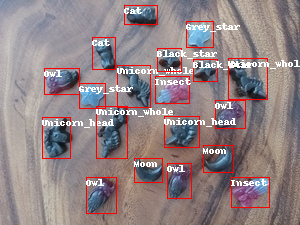

In [ ]:
#view labelled image from candy data
image = candy_data["train"][0]["image"]
annotations = candy_data["train"][0]["objects"]
draw = ImageDraw.Draw(image)

id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [ ]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [ ]:
candy_data["train"] = candy_data["train"].with_transform(transform_aug_ann)
candy_data["train"][2]

{'pixel_values': tensor([[[ 0.0741,  0.0912,  0.1254,  ..., -0.7479, -0.7479, -0.7479],
          [ 0.0741,  0.0912,  0.1254,  ..., -0.7479, -0.7479, -0.7479],
          [ 0.0741,  0.0912,  0.1254,  ..., -0.7308, -0.7308, -0.7308],
          ...,
          [ 1.0159,  1.0159,  1.0331,  ..., -0.5082, -0.5424, -0.5596],
          [ 1.0331,  1.0331,  1.0502,  ..., -0.5253, -0.5596, -0.5767],
          [ 1.0331,  1.0331,  1.0502,  ..., -0.5424, -0.5596, -0.5767]],
 
         [[ 0.2927,  0.3102,  0.3277,  ..., -0.6702, -0.6702, -0.6702],
          [ 0.2927,  0.3102,  0.3277,  ..., -0.6702, -0.6702, -0.6702],
          [ 0.2927,  0.3102,  0.3277,  ..., -0.6527, -0.6527, -0.6527],
          ...,
          [ 0.9055,  0.9230,  0.9405,  ..., -0.2150, -0.2675, -0.3025],
          [ 0.9230,  0.9405,  0.9580,  ..., -0.2500, -0.2850, -0.3200],
          [ 0.9405,  0.9405,  0.9580,  ..., -0.2850, -0.3025, -0.3200]],
 
         [[ 0.9145,  0.9319,  0.9494,  ..., -0.3230, -0.3230, -0.3230],
          [ 

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir= "detr-resnet-50_finetuned_candy_data",
    per_device_train_batch_size=3,
    num_train_epochs=100,
    save_steps=200,
    logging_steps=9,
    learning_rate=5e-6,
    weight_decay=1e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data["train"],
    tokenizer=image_processor,
)

trainer.train()


Step,Training Loss
9,1.796700
18,1.791300
27,1.797000
36,1.752700
45,1.750200
54,1.726700
63,1.726800
72,1.701800
81,1.696200
90,1.687100


TrainOutput(global_step=300, training_loss=1.6270719973246257, metrics={'train_runtime': 170.7238, 'train_samples_per_second': 5.272, 'train_steps_per_second': 1.757, 'total_flos': 4.30042214016e+17, 'train_loss': 1.6270719973246257, 'epoch': 100.0})

In [ ]:
trainer.save_model('candy_detector')

In [ ]:
#download model
import shutil
from google.colab import files

shutil.make_archive('candy_detector', 'zip', 'candy_detector')

files.download('candy_detector.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#load saved model
def load_model(model_path):
  zip_file_path = model_path
  # Set the directory where you want to extract the contents
  extract_path = 'candy_detector_loaded'
  # Create the extraction directory if it doesn't exist
  os.makedirs(extract_path, exist_ok=True)

  # Unzip the folder
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

  #load model
  obj_detector = pipeline("object-detection", model="candy_detector_loaded")

  return obj_detector

candy_detector = load_model('candy_detector.zip')


In [ ]:
#display image predictions
def image_display(image):
  image = Image.open(image)
  draw = ImageDraw.Draw(image)
  #load model
  obj_detector = candy_detector
  results = obj_detector(image, threshold=0.25)
  for result in results:
    score = result["score"]
    label = result["label"]
    box = result["box"]

    box = [round(box['xmin'], 2), round(box['ymin'], 2), round(box['xmax'], 2), round(box['ymax'], 2)]
    x, y, x2, y2 = tuple(box)

    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), label, fill="white")
  # Show the image using IPython.display
  return image


In [ ]:
def candy_counter(image):
  image = Image.open(image)
  draw = ImageDraw.Draw(image)
  #load model
  obj_detector = candy_detector
  results = obj_detector(image, threshold=0.25)
  label_counts = {}
  for result in results:
    label = result["label"]
    # Update label count dictionary
    label_counts[label] = label_counts.get(label, 0) + 1

  return label_counts

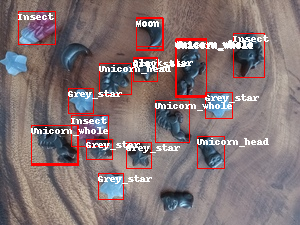

In [ ]:
image1 = image_display('test/88833873-cd_08.jpg')
display(image1)

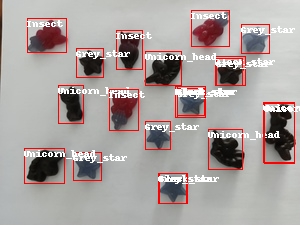

In [ ]:
image2 = image_display('test/ddf5f829-cd_24.jpg')
display(image2)

In [ ]:
image1label =  candy_counter('/content/test/88833873-cd_08.jpg')
image1label

{'Black_star': 1,
 'Unicorn_whole': 7,
 'Moon': 3,
 'Grey_star': 6,
 'Insect': 3,
 'Unicorn_head': 2}

In [ ]:
image2label = candy_counter('/content/test/ddf5f829-cd_24.jpg')
image2label

{'Insect': 4,
 'Black_star': 4,
 'Unicorn_head': 5,
 'Grey_star': 7,
 'Unicorn_whole': 1}